In [8]:
import numpy as np
import matplotlib.pyplot as plt
import compress_pickle as pickle
from scipy import stats

In [9]:
def process_mice_data(mice_data):
    """
    mice_data : dict
        Dictionary where keys are mouse names and values are dicts with:
        - 'session_files': list of paths to .gz files for that mouse
        - 'speed_files': list of paths to .txt files for that mouse
    
    Returns dict containing:
        - 'common_speeds': sorted array of unique speeds across all mice
        - 'go_matrix': 2D array (n_mice x n_speeds) of go trial probabilities
        - 'nogo_matrix': 2D array (n_mice x n_speeds) of no-go trial probabilities
        - 'mouse_names': list of mouse names in order
        - 'all_mouse_data': dict with individual mouse data
    """
    
    # Storage for each mouse's data
    all_mouse_data = {}
    all_unique_speeds = set()
    
    # Process each mouse
    for mouse_name, files in mice_data.items():
        print(f"\n{'='*60}")
        print(f"Processing {mouse_name}")
        print('='*60)
        
        session_files = files['session_files']
        speed_files = files['speed_files']
        
        if len(session_files) != len(speed_files):
            raise ValueError(f"{mouse_name}: Number of session files must match number of speed files")
        
        # Collect data from all sessions for this mouse
        all_speeds = []
        all_results = []
        
        for behavior_path, speed_path in zip(session_files, speed_files):
            print(f"  Loading {behavior_path}")
            
            # Load behavior data
            with open(behavior_path, "rb") as f:
                session_data = pickle.load(f)
            
            results = np.array(session_data["results"])
            
            # Load speeds
            with open(speed_path, "r") as f:
                speed_text = f.read().strip()
                speeds = np.array([float(x.strip()) for x in speed_text.split(",")])
            
            # Verify lengths match
            if len(speeds) != len(results):
                print(f"    Warning: {len(speeds)} speeds but {len(results)} trials")
                min_len = min(len(speeds), len(results))
                speeds = speeds[:min_len]
                results = results[:min_len]
            
            print(f"    Loaded {len(results)} trials")
            
            all_speeds.append(speeds)
            all_results.append(results)
        
        # Combine sessions for this mouse
        combined_speeds = np.concatenate(all_speeds)
        combined_results = np.concatenate(all_results)
        
        print(f"  Total trials for {mouse_name}: {len(combined_results)}")
        
        # Get unique speeds for this mouse
        unique_speeds = np.unique(combined_speeds)
        all_unique_speeds.update(unique_speeds)
        
        # Calculate p(lick) for each speed
        go_probs = {}
        nogo_probs = {}
        
        for speed in unique_speeds:
            speed_mask = combined_speeds == speed
            speed_results = combined_results[speed_mask]
            
            # Go trials
            go_trials = (speed_results == "hit") | (speed_results == "miss")
            if np.sum(go_trials) > 0:
                hits = np.sum(speed_results == "hit")
                go_probs[speed] = hits / np.sum(go_trials)
            else:
                go_probs[speed] = np.nan
            
            # No-go trials
            nogo_trials = (speed_results == "FA") | (speed_results == "CR")
            if np.sum(nogo_trials) > 0:
                fas = np.sum(speed_results == "FA")
                nogo_probs[speed] = fas / np.sum(nogo_trials)
            else:
                nogo_probs[speed] = np.nan
        
        all_mouse_data[mouse_name] = {
            'go_probs': go_probs,
            'nogo_probs': nogo_probs
        }
    
    # Get common speeds across all mice
    common_speeds = np.sort(list(all_unique_speeds))
    
    # Organize data for plotting
    go_matrix = []
    nogo_matrix = []
    mouse_names = list(mice_data.keys())
    
    for mouse_name in mouse_names:
        go_row = [all_mouse_data[mouse_name]['go_probs'].get(speed, np.nan) for speed in common_speeds]
        nogo_row = [all_mouse_data[mouse_name]['nogo_probs'].get(speed, np.nan) for speed in common_speeds]
        go_matrix.append(go_row)
        nogo_matrix.append(nogo_row)
    
    go_matrix = np.array(go_matrix)
    nogo_matrix = np.array(nogo_matrix)
    
    # Print summary
    print("\n" + "="*60)
    print("DATA PROCESSING COMPLETE")
    print("="*60)
    print(f"Number of mice: {len(mice_data)}")
    print(f"Number of unique speeds: {len(common_speeds)}")
    print(f"Speeds tested: {common_speeds}")
    
    return {
        'common_speeds': common_speeds,
        'go_matrix': go_matrix,
        'nogo_matrix': nogo_matrix,
        'mouse_names': mouse_names,
        'all_mouse_data': all_mouse_data
    }



mice_data = {
    'BQK2': {
        'session_files': [
            "N:/Lee_Yuna/projects/WT_behavior/BQK2_HP1_DONE/20260117_150513_BQK2_REVERSE_SPEEDS.gz",
            "N:/Lee_Yuna/projects/WT_behavior/BQK2_HP1_DONE/20260118_145831_BQK2_REVERSE_SPEEDS.gz"
        ],
        'speed_files': [
            "N:/Lee_Yuna/projects/WT_behavior/BQK2_HP1_DONE/20260117_150513_BQK2_REVERSE_SPEEDS_LIST.txt",
            "N:/Lee_Yuna/projects/WT_behavior/BQK2_HP1_DONE/20260118_145831_BQK2_REVERSE_SPEEDS_LIST.txt"
        ]
    },
    'BQK3': {
        'session_files': [
            "N:/Lee_Yuna/projects/WT_behavior/BQK3_HP2_DONE/20260108_172949_BQK3_REVERSE_SPEEDS.gz",
            "N:/Lee_Yuna/projects/WT_behavior/BQK3_HP2_DONE/20260109_095333_BQK3_REVERSE_SPEED.gz"
        ],
        'speed_files': [
            "N:/Lee_Yuna/projects/WT_behavior/BQK3_HP2_DONE/20260108_172949_BQK3_REVERSE_SPEEDS_LIST.txt",
            "N:/Lee_Yuna/projects/WT_behavior/BQK3_HP2_DONE/20260109_095333_BQK3_REVERSE_SPEED_LIST.txt"
        ]
    },
    'BQK4': {
        'session_files': [
            "N:/Lee_Yuna/projects/WT_behavior/BQK4_HP3_DONE/20260109_105540_BQK4_REVERSE_SPEED.gz",
            "N:/Lee_Yuna/projects/WT_behavior/BQK4_HP3_DONE/20260111_165453_BQK4_REVERSE_SPEED.gz"
        ],
        'speed_files': [
            "N:/Lee_Yuna/projects/WT_behavior/BQK4_HP3_DONE/20260109_105540_BQK4_REVERSE_SPEED_LIST.txt",
            "N:/Lee_Yuna/projects/WT_behavior/BQK4_HP3_DONE/20260111_165453_BQK4_REVERSE_SPEED_LIST.txt"
        ]
    },
    'BQV3': {
        'session_files': [
            "N:/Lee_Yuna/projects/WT_behavior/BQV3_HP4_DONE/20260113_142755_BQV3_REVERSE_SPEEDS.gz",
            "N:/Lee_Yuna/projects/WT_behavior/BQV3_HP4_DONE/20260115_103509_BQV3_REVERSE_SPEEDS.gz"
        ],
        'speed_files': [
            "N:/Lee_Yuna/projects/WT_behavior/BQV3_HP4_DONE/20260113_142755_BQV3_REVERSE_SPEEDS_LIST.txt",
            "N:/Lee_Yuna/projects/WT_behavior/BQV3_HP4_DONE/20260115_103509_BQV3_REVERSE_SPEEDS_LIST.txt"
        ]
    },
    'BQV4': {
        'session_files': [
            "N:/Lee_Yuna/projects/WT_behavior/BQV4_HP5_DONE/20260115_114219_BQV4_REVERSE_SPEEDS.gz",
            "N:/Lee_Yuna/projects/WT_behavior/BQV4_HP5_DONE/20260116_102405_BQV4_REVERSE_SPEEDS.gz"
        ],
        'speed_files': [
            "N:/Lee_Yuna/projects/WT_behavior/BQV4_HP5_DONE/20260115_114219_BQV4_REVERSE_SPEEDS_LIST.txt",
            "N:/Lee_Yuna/projects/WT_behavior/BQV4_HP5_DONE/20260116_102405_BQV4_REVERSE_SPEEDS_LIST.txt"
        ]
    },
    'BQV5': {
        'session_files': [
            "N:/Lee_Yuna/projects/WT_behavior/BQV5_HP6_DONE/20260117_161647_BQV5_REVERSE_SPEEDS.gz",
            "N:/Lee_Yuna/projects/WT_behavior/BQV5_HP6_DONE/20260118_160216_BQV5_REVERSE_SPEEDS.gz"
        ],
        'speed_files': [
            "N:/Lee_Yuna/projects/WT_behavior/BQV5_HP6_DONE/20260117_161647_BQV5_REVERSE_SPEEDS_LIST.txt",
            "N:/Lee_Yuna/projects/WT_behavior/BQV5_HP6_DONE/20260118_160216_BQV5_REVERSE_SPEEDS_LIST.txt"
        ]
    }
}

processed_data = process_mice_data(mice_data)


Processing BQK2
  Loading N:/Lee_Yuna/projects/WT_behavior/BQK2_HP1_DONE/20260117_150513_BQK2_REVERSE_SPEEDS.gz
    Loaded 300 trials
  Loading N:/Lee_Yuna/projects/WT_behavior/BQK2_HP1_DONE/20260118_145831_BQK2_REVERSE_SPEEDS.gz
    Loaded 300 trials
  Total trials for BQK2: 600

Processing BQK3
  Loading N:/Lee_Yuna/projects/WT_behavior/BQK3_HP2_DONE/20260108_172949_BQK3_REVERSE_SPEEDS.gz
    Loaded 300 trials
  Loading N:/Lee_Yuna/projects/WT_behavior/BQK3_HP2_DONE/20260109_095333_BQK3_REVERSE_SPEED.gz
    Loaded 300 trials
  Total trials for BQK3: 600

Processing BQK4
  Loading N:/Lee_Yuna/projects/WT_behavior/BQK4_HP3_DONE/20260109_105540_BQK4_REVERSE_SPEED.gz
    Loaded 300 trials
  Loading N:/Lee_Yuna/projects/WT_behavior/BQK4_HP3_DONE/20260111_165453_BQK4_REVERSE_SPEED.gz
    Loaded 300 trials
  Total trials for BQK4: 600

Processing BQV3
  Loading N:/Lee_Yuna/projects/WT_behavior/BQV3_HP4_DONE/20260113_142755_BQV3_REVERSE_SPEEDS.gz
    Loaded 74 trials
  Loading N:/Lee_Yuna/p

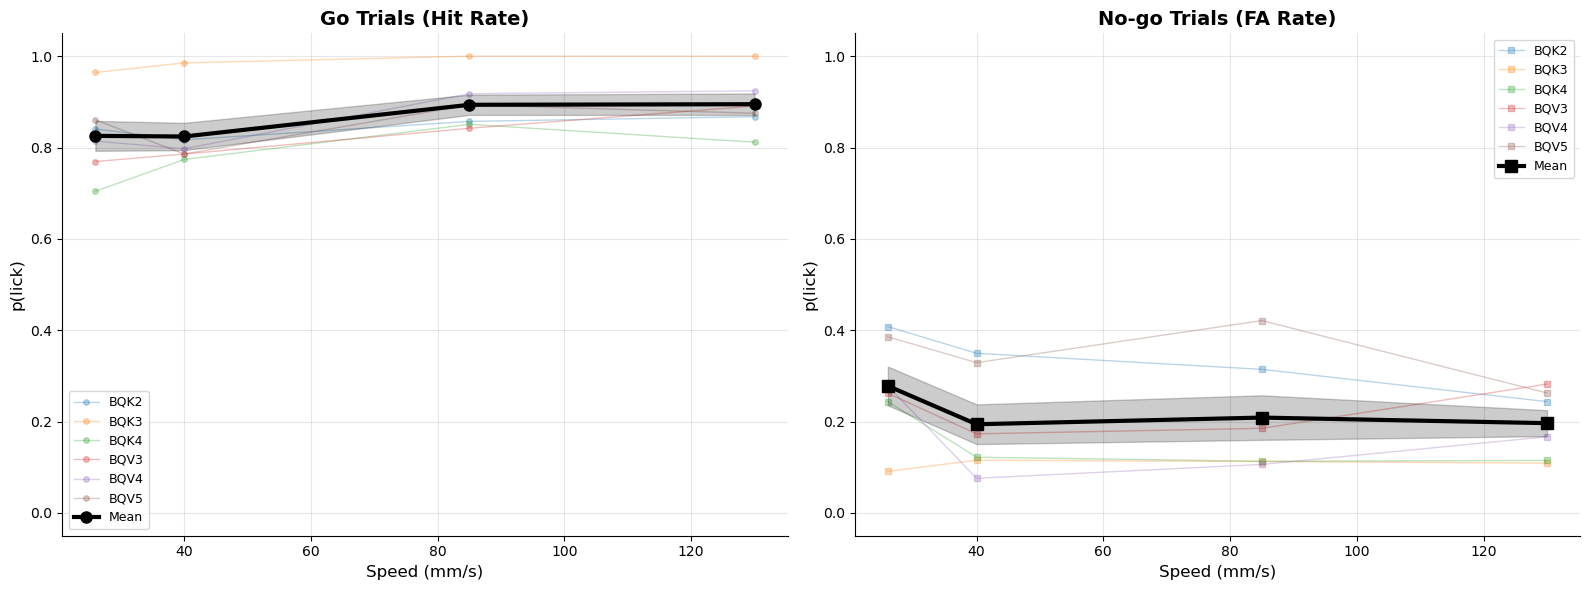


GROUP SUMMARY
Number of mice: 6

Go trials (Hit Rate) by speed:
  Speed   26.0 mm/s: Mean=0.826, SEM=0.033, n=6 mice
  Speed   40.0 mm/s: Mean=0.824, SEM=0.030, n=6 mice
  Speed   85.0 mm/s: Mean=0.894, SEM=0.022, n=6 mice
  Speed  130.0 mm/s: Mean=0.895, SEM=0.024, n=6 mice

No-go trials (FA Rate) by speed:
  Speed   26.0 mm/s: Mean=0.278, SEM=0.042, n=6 mice
  Speed   40.0 mm/s: Mean=0.194, SEM=0.044, n=6 mice
  Speed   85.0 mm/s: Mean=0.209, SEM=0.049, n=6 mice
  Speed  130.0 mm/s: Mean=0.196, SEM=0.028, n=6 mice


In [7]:
def plot_speed_vs_lick_results(processed_data):
    """
    processed_data : dict
        Output from process_mice_data() containing:
        - 'common_speeds': array of speeds
        - 'go_matrix': 2D array of go probabilities
        - 'nogo_matrix': 2D array of no-go probabilities
        - 'mouse_names': list of mouse names
    """
    
    common_speeds = processed_data['common_speeds']
    go_matrix = processed_data['go_matrix']
    nogo_matrix = processed_data['nogo_matrix']
    mouse_names = processed_data['mouse_names']
    
    # Convert speeds: 50→26, 77→40, 166→85, 255→130 mm/s
    speed_conversion = {
        50: 26,
        77: 40,
        166: 85,
        255: 130
    }
    
    # Convert speeds to mm/s
    speeds_mm_s = np.array([speed_conversion.get(speed, speed) for speed in common_speeds])
    
    # Calculate mean and SEM
    go_mean = np.nanmean(go_matrix, axis=0)
    go_sem = np.nanstd(go_matrix, axis=0) / np.sqrt(np.sum(~np.isnan(go_matrix), axis=0))
    
    nogo_mean = np.nanmean(nogo_matrix, axis=0)
    nogo_sem = np.nanstd(nogo_matrix, axis=0) / np.sqrt(np.sum(~np.isnan(nogo_matrix), axis=0))
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot Go trials
    # Individual mice 
    for i, mouse_name in enumerate(mouse_names):
        ax1.plot(speeds_mm_s, go_matrix[i, :], 'o-', alpha=0.3, linewidth=1, 
                markersize=4, label=mouse_name)
    
    # Mean ± SEM 
    ax1.plot(speeds_mm_s, go_mean, 'o-', color='black', linewidth=3, 
            markersize=8, label='Mean', zorder=10)
    ax1.fill_between(speeds_mm_s, go_mean - go_sem, go_mean + go_sem, 
                     color='black', alpha=0.2, zorder=9)
    
    ax1.set_xlabel('Speed (mm/s)', fontsize=12)
    ax1.set_ylabel('p(lick)', fontsize=12)
    ax1.set_title('Go Trials (Hit Rate)', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_ylim(-0.05, 1.05)
    
    # Plot No-go trials
    # Individual mice 
    for i, mouse_name in enumerate(mouse_names):
        ax2.plot(speeds_mm_s, nogo_matrix[i, :], 's-', alpha=0.3, linewidth=1,
                markersize=4, label=mouse_name)
    
    # Mean ± SEM 
    ax2.plot(speeds_mm_s, nogo_mean, 's-', color='black', linewidth=3,
            markersize=8, label='Mean', zorder=10)
    ax2.fill_between(speeds_mm_s, nogo_mean - nogo_sem, nogo_mean + nogo_sem,
                     color='black', alpha=0.2, zorder=9)
    
    ax2.set_xlabel('Speed (mm/s)', fontsize=12)
    ax2.set_ylabel('p(lick)', fontsize=12)
    ax2.set_title('No-go Trials (FA Rate)', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_ylim(-0.05, 1.05)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("GROUP SUMMARY")
    print("="*60)
    print(f"Number of mice: {len(mouse_names)}")
    print(f"\nGo trials (Hit Rate) by speed:")
    for i, speed in enumerate(common_speeds):
        speed_mm_s = speed_conversion.get(speed, speed)
        n_mice = np.sum(~np.isnan(go_matrix[:, i]))
        print(f"  Speed {speed_mm_s:6.1f} mm/s: Mean={go_mean[i]:.3f}, SEM={go_sem[i]:.3f}, n={n_mice} mice")
    
    print(f"\nNo-go trials (FA Rate) by speed:")
    for i, speed in enumerate(common_speeds):
        speed_mm_s = speed_conversion.get(speed, speed)
        n_mice = np.sum(~np.isnan(nogo_matrix[:, i]))
        print(f"  Speed {speed_mm_s:6.1f} mm/s: Mean={nogo_mean[i]:.3f}, SEM={nogo_sem[i]:.3f}, n={n_mice} mice")
    
    return go_mean, go_sem, nogo_mean, nogo_sem

go_mean, go_sem, nogo_mean, nogo_sem = plot_speed_vs_lick_results(processed_data)